# Goal of this notebook: examine whether somatic mutations at putative eSTRs result in the expected changes in expression levels between patient-matched healthy and tumor tissues

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd

sns.set_context("poster")
%matplotlib inline

## Load data, identify eSTR mutations
Gene expression, eSTR correlations, and STR genotyping data are used to identify mutations at eSTR loci in the test set. These mutations are collected in the `df_estr_mutations` data frame.


In [2]:
df_genexp_test = pd.read_csv("../../data/gene_expression/dummy_tumor_gene_expression_test_normalized.csv")
df_correlations = pd.read_csv("../../results/gene_expression/dummy_gene_str_length_correlations.csv")

df_somatic_mutations = pd.read_csv("../../data/dummy_somatic_mutation_calls_filt.csv")
df_somatic_mutations = df_somatic_mutations.loc[df_somatic_mutations["patient"].isin(df_genexp_test["patient"]), :]


In [3]:
alpha = 0.001
df_estr_mutations = (df_correlations
    .query(f"pvalue_corrected < {alpha}")
    .merge(df_somatic_mutations, on='tmp_id', how='inner')
    .assign(
        mean_gt_healthy = lambda x: (x.allele_a_healthy + x.allele_b_healthy) / 2,
        mean_gt_tumor = lambda x: (x.allele_a_tumor + x.allele_b_tumor) / 2,
        patient_mean_diff = lambda x:  x.mean_gt_tumor - x.mean_gt_healthy
    )
    .query("patient_mean_diff != 0")
    .filter(['patient', 'gene', 'tmp_id', 'coefficient', 'pvalue_corrected', 'period', 'mean_gt_healthy', 'mean_gt_tumor', 'patient_mean_diff'])   
)

df_estr_mutations

,patient,gene,tmp_id,coefficient,pvalue_corrected,period,mean_gt_healthy,mean_gt_tumor,patient_mean_diff
39,49,J,chr1_6834638,-1.688704,1.188573e-08,1,18.0,17.0,-1.0
44,24,P,chr1_10662707,1.756451,8.294841e-07,2,5.0,4.5,-0.5
47,37,P,chr1_10662707,1.756451,8.294841e-07,2,5.0,3.0,-2.0
49,49,P,chr1_10662707,1.756451,8.294841e-07,2,5.0,3.0,-2.0
53,17,M,chr1_9691434,1.537430,2.409122e-05,4,5.0,7.0,2.0
56,34,M,chr1_9691434,1.537430,2.409122e-05,4,5.0,3.0,-2.0
58,42,M,chr1_9691434,1.537430,2.409122e-05,4,5.0,3.5,-1.5


Next, gene expression data is added to the eSTR mutation data in `df_estr_mutations`. For the purpose of demonstration, we simulate the gene expression levels for the healthy sample directly from the tumor expression level using the eSTR coefficient. With real data there should be actual gene expression information from both a tumor and a patient-matched healthy sample.

In [4]:
df_estr_mutations = (
    df_estr_mutations
        .merge(df_genexp_test, on=['patient', 'gene'], how='inner')
        .rename(columns={"expression": "expression_tumor"})
        .assign(
            # Simulate healthy expression from tumor expression using eSTR coefficient
            expression_healthy = lambda x: x.expression_tumor - (x.patient_mean_diff * x.coefficient),
            genexp_diff = lambda x: x.expression_tumor - x.expression_healthy)
)

df_estr_mutations

,patient,gene,tmp_id,coefficient,pvalue_corrected,period,mean_gt_healthy,mean_gt_tumor,patient_mean_diff,expression_tumor,expression_healthy,genexp_diff
0,49,J,chr1_6834638,-1.688704,1.188573e-08,1,18.0,17.0,-1.0,2.066827,0.378123,1.688704
1,24,P,chr1_10662707,1.756451,8.294841e-07,2,5.0,4.5,-0.5,-0.158780,0.719445,-0.878226
2,37,P,chr1_10662707,1.756451,8.294841e-07,2,5.0,3.0,-2.0,-1.799160,1.713743,-3.512903
3,49,P,chr1_10662707,1.756451,8.294841e-07,2,5.0,3.0,-2.0,-1.799160,1.713743,-3.512903
4,17,M,chr1_9691434,1.537430,2.409122e-05,4,5.0,7.0,2.0,2.167486,-0.907374,3.074860
5,34,M,chr1_9691434,1.537430,2.409122e-05,4,5.0,3.0,-2.0,-1.928339,1.146521,-3.074860
6,42,M,chr1_9691434,1.537430,2.409122e-05,4,5.0,3.5,-1.5,-0.636962,1.669183,-2.306145


## Check if gene expression changes are consistent with eSTR coefficients

In [5]:
def expected_change(row):
    if row.coefficient > 0:
        if row.patient_mean_diff > 0:
            # coef positive and increase in STR length, expect an increase in expression
            if row.genexp_diff > 0:
                return True
        elif row.patient_mean_diff < 0:
            # coef positive and decrease in STR length, expect a decrease in expression
            if row.genexp_diff < 0:
                return True
    elif row.coefficient < 0:
        if row.patient_mean_diff > 0:
            # coef negative and increase in STR length, expect a decrease in expression
            if row.genexp_diff < 0:
                return True
        elif row.patient_mean_diff < 0:
            # coef negative and decrease in STR length, expect an increase in expression
            if row.genexp_diff > 0:
                return True
    return False
                

Check whether observed difference in expression between healthy and tumor matches expectation based on eSTR coefficient. Furthermore, calculate an expected mutation impact, which is defined by multiplying the absolute value of the eSTR coefficient with the difference in STR length between two samples. 

In [6]:
df_estr_mutations['expected_change'] = df_estr_mutations.apply(expected_change, axis=1)
df_estr_mutations = df_estr_mutations.assign(exp_mutation_impact = abs(df_estr_mutations.coefficient * df_estr_mutations.patient_mean_diff))
df_estr_mutations.head()

,patient,gene,tmp_id,coefficient,pvalue_corrected,period,mean_gt_healthy,mean_gt_tumor,patient_mean_diff,expression_tumor,expression_healthy,genexp_diff,expected_change,exp_mutation_impact
0,49,J,chr1_6834638,-1.688704,1.188573e-08,1,18.0,17.0,-1.0,2.066827,0.378123,1.688704,True,1.688704
1,24,P,chr1_10662707,1.756451,8.294841e-07,2,5.0,4.5,-0.5,-0.158780,0.719445,-0.878226,True,0.878226
2,37,P,chr1_10662707,1.756451,8.294841e-07,2,5.0,3.0,-2.0,-1.799160,1.713743,-3.512903,True,3.512903
3,49,P,chr1_10662707,1.756451,8.294841e-07,2,5.0,3.0,-2.0,-1.799160,1.713743,-3.512903,True,3.512903
4,17,M,chr1_9691434,1.537430,2.409122e-05,4,5.0,7.0,2.0,2.167486,-0.907374,3.074860,True,3.074860


Assign eSTR mutations to quartiles based on the expected mutation impact, determine the accuracy of each quartile.

In [7]:
df_estr_mutations = (
    df_estr_mutations
        .sort_values("exp_mutation_impact")
        .assign(
            exp_mut_impact_quartile = (pd.cut(range(0, len(df_estr_mutations)), bins=4).codes + 1)
        )
)

df_estr_mutations

,patient,gene,tmp_id,coefficient,pvalue_corrected,period,mean_gt_healthy,mean_gt_tumor,patient_mean_diff,expression_tumor,expression_healthy,genexp_diff,expected_change,exp_mutation_impact,exp_mut_impact_quartile
1,24,P,chr1_10662707,1.756451,8.294841e-07,2,5.0,4.5,-0.5,-0.158780,0.719445,-0.878226,True,0.878226,1
0,49,J,chr1_6834638,-1.688704,1.188573e-08,1,18.0,17.0,-1.0,2.066827,0.378123,1.688704,True,1.688704,1
6,42,M,chr1_9691434,1.537430,2.409122e-05,4,5.0,3.5,-1.5,-0.636962,1.669183,-2.306145,True,2.306145,2
4,17,M,chr1_9691434,1.537430,2.409122e-05,4,5.0,7.0,2.0,2.167486,-0.907374,3.074860,True,3.074860,2
5,34,M,chr1_9691434,1.537430,2.409122e-05,4,5.0,3.0,-2.0,-1.928339,1.146521,-3.074860,True,3.074860,3
2,37,P,chr1_10662707,1.756451,8.294841e-07,2,5.0,3.0,-2.0,-1.799160,1.713743,-3.512903,True,3.512903,4
3,49,P,chr1_10662707,1.756451,8.294841e-07,2,5.0,3.0,-2.0,-1.799160,1.713743,-3.512903,True,3.512903,4


In [17]:
df_estr_mutations[["exp_mut_impact_quartile", "expected_change"]].groupby("exp_mut_impact_quartile").agg(["mean", "size"]).rename(columns={"mean": "accuracy", "sum": "n_observations"})



expected_change     
                               accuracy size
exp_mut_impact_quartile                     
1                                   1.0    2
2                                   1.0    2
3                                   1.0    1
4                                   1.0    2

For plotting purposes, define bins for expected mutation impact (so not necessarily quartiles). Calculate the accuracy of each bin.

In [9]:
nbins = 3

df_barplot = (
    df_estr_mutations
        .drop(["patient", "gene", "tmp_id"], axis=1)
        .assign(exp_impact_bin = pd.cut(df_estr_mutations.exp_mutation_impact, nbins))
        .groupby("exp_impact_bin")
        .agg("mean")
        .rename(columns = {"expected_change": "bin_accuracy"})
        .sort_index(ascending=True)
) 

print(min(df_barplot.bin_accuracy))
df_barplot

1.0


,coefficient,pvalue_corrected,period,mean_gt_healthy,mean_gt_tumor,patient_mean_diff,expression_tumor,expression_healthy,genexp_diff,bin_accuracy,exp_mutation_impact,exp_mut_impact_quartile
exp_impact_bin,,,,,,,,,,,,
"(0.876, 1.756]",0.033874,4.206849e-07,1.5,11.5,10.75,-0.75,0.954023,0.548784,0.405239,1.0,1.283465,1.00
"(1.756, 2.635]",1.537430,2.409122e-05,4.0,5.0,3.50,-1.50,-0.636962,1.669183,-2.306145,1.0,2.306145,2.00
"(2.635, 3.513]",1.646941,1.246035e-05,3.0,5.0,4.00,-1.00,-0.839793,0.916658,-1.756451,1.0,3.293882,3.25


For demonstration purposes, we hard-code some of the bins to have different accuracy values

In [10]:
df_barplot.iloc[0, :]["bin_accuracy"] = 0.5
df_barplot.iloc[1, :]["bin_accuracy"] = 0.75
df_barplot

,coefficient,pvalue_corrected,period,mean_gt_healthy,mean_gt_tumor,patient_mean_diff,expression_tumor,expression_healthy,genexp_diff,bin_accuracy,exp_mutation_impact,exp_mut_impact_quartile
exp_impact_bin,,,,,,,,,,,,
"(0.876, 1.756]",0.033874,4.206849e-07,1.5,11.5,10.75,-0.75,0.954023,0.548784,0.405239,0.50,1.283465,1.00
"(1.756, 2.635]",1.537430,2.409122e-05,4.0,5.0,3.50,-1.50,-0.636962,1.669183,-2.306145,0.75,2.306145,2.00
"(2.635, 3.513]",1.646941,1.246035e-05,3.0,5.0,4.00,-1.00,-0.839793,0.916658,-1.756451,1.00,3.293882,3.25


In [26]:
def colors_from_values(values, palette_name):
    values = values.fillna(values.min())

    # normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return (values.min(), values.max()), np.array(palette).take(indices, axis=0)


(0.5, 1.0)


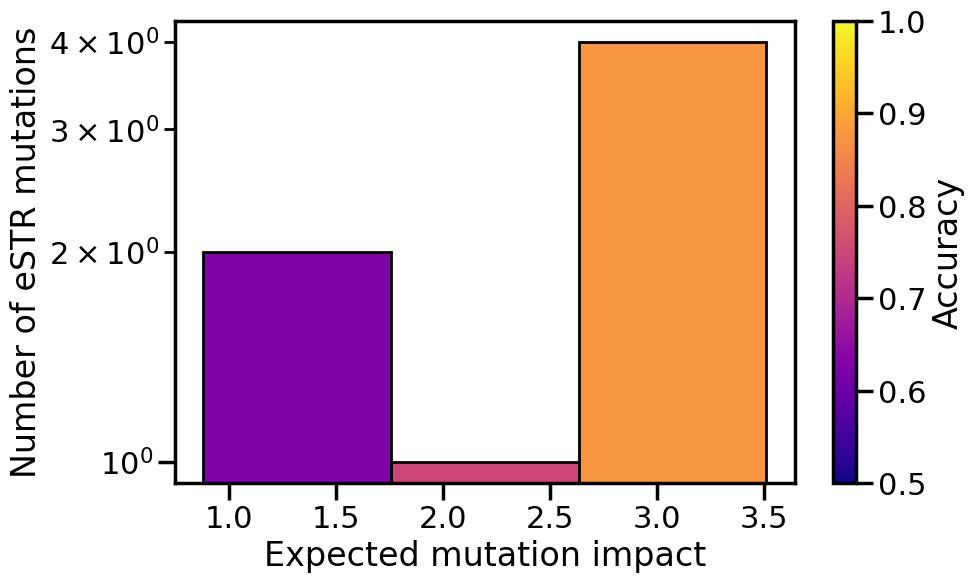

In [27]:
import matplotlib as mpl
from matplotlib import cm
fig, ax = plt.subplots(1, 1, figsize = (10, 6))

ax = sns.histplot(
    data = df_estr_mutations,
    x = "exp_mutation_impact",
    bins=nbins,
    ax = ax
)

# cmap = "YlOrRd"
cmap = "plasma"
limits, facecolors = colors_from_values(df_barplot["bin_accuracy"], cmap)
print(limits)

for bin_, i in zip(ax.patches, facecolors):
    bin_.set_facecolor(i)

plt.colorbar(
    cm.ScalarMappable(
        norm=mpl.colors.Normalize(vmin=limits[0], vmax=limits[1]),  
        cmap=mpl.colormaps[cmap],        
    ),
    label="Accuracy",
    ax = ax
)

ax.set(
    xlabel = "Expected mutation impact",
    ylabel = "Number of eSTR mutations",
    yscale = "log"
)

plt.show()